# Web Search 2018 - Phase 2

### <a name="head11"></a> Code Imports

In [1]:
from tokenizer import tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import pandas as pd
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.preprocessing import normalize
from skimage import color
from skimage import data, exposure
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt
import sys
import random
from numpy.random import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from skimage import img_as_ubyte
import warnings
import os
import time
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
warnings.filterwarnings('ignore')

print(os.getcwd(), "changing to:", os.getcwd()+"/../")

# Change this according to the path where you have the ws_toolkit
ws_toolkit_path = os.getcwd()+"/.."

os.chdir(ws_toolkit_path)
print(os.getcwd())
from ws_toolkit.utils import center_crop_image, k_neighbours, hoc, init_bow, process_images_keras

Using TensorFlow backend.


/Users/franciscorodrigues/Projects/PW/pw_phase3/project changing to: /Users/franciscorodrigues/Projects/PW/pw_phase3/project/../
/Users/franciscorodrigues/Projects/PW/pw_phase3
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/franciscorodrigues/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Global Variables

In [2]:
# Cached arrays
croppedImages = []
X_HOC = None
X_HOG = None
X_BOW = None
X_CNN = None
CNN_PREDICTIONS = []

### Features

In [3]:
def computeFeatures():
    pixels_per_cell = (32, 32)
    orientations = 8
    
    bins = (4,4,4)
    hsv = True
    
    _lemmatize=False
    _mdf=3
    _metric="cosine"
    _k=10
    _handles=False
    _hashes=False
    _case=False
    _url=False
    
    return features_hog(croppedImages, pixels_per_cell, orientations), getColorMatrix(croppedImages, bins, hsv), execute_bow(tweets, _lemmatize, _mdf, _metric, _k, _handles, _hashes, _case, _url), getTagsBow(imageLinks)

# Pre-Processing

In [4]:
# Read dataset .csv
df = pd.read_csv("./visualstories_edfest_2016_twitter_xmedia.csv",
                 sep=';', encoding="utf-8")

data = np.array([df.get("text").values, df.get(
    "image-url").values, df.get("gt_class").values])
# This are the text of the tweets
tweets = data[0]
# This are the links of the images of the tweets (ex: C0zsADasd213.jpg)
imageLinks = [i.replace('https://pbs.twimg.com/media/', '') for i in data[1]]
# This are the arrays of the data of each cropped image
targets = [list(map(int, c.replace(' ', '').split(","))) for c in data[2]]
# Save cropped images in cache
croppedImages = cropImageList(croppedImages, imageLinks)

# Compute Cached Features Spaces

In [5]:
# Cache features
X_HOG, X_HOC, X_BOW, X_CNN, CNN_PREDICTIONS = computeFeatures()

Processed Images finished: 39.90178823471069
No Cached Predictions
Model Predictions finished: 822.3856117725372


# Iterative Label Propagation Implementation

In [6]:
def runAlg(mlb, images, y, y_true, features, weights, selection, topk, threshold, alpha, iterations, params=None, mf = False, indices_unlabeled=[]):

    # Step 2 - Normalize Y and Initialize matrix F with Y
    Y_hidden = normalize(y, axis = 1, norm="l1")
    F = Y_hidden
    #print(F[indices_labeled[0],:])
    
    # Step 3 - Compute matrix W (multi feature -mf true; or single feature -mf false)
    W = []
    if mf is True:
        M = None
        for i in range(len(features)):
            M = weights[i]*euclidean_distances(features[i], features[i])
        #M = weights[0]*euclidean_distances(feature[0], feature[0]) + weights[1]*euclidean_distances(feature[1], feature[1])
    else:
        M = euclidean_distances(features[0], features[0])
        
    sigma = np.std(M)
    W = np.exp(-1 * M / (2*sigma**2))

    # Step 4 - Normalize W
    D = np.zeros(W.shape)
    np.fill_diagonal(D, W.sum(axis=0))

    D12 = np.zeros(D.shape)
    from numpy.linalg import inv
    D12 = inv(np.sqrt(D))

    S = np.dot(D12, W)
    S = np.dot(S, D12)

    # Step 5 - Perform the F update step num_iterations steps
    for i in range(1, iterations):
        T1 = alpha * S
        T1 = np.dot(T1, F)
        T2 =  (1 - alpha) * Y_hidden
        F = T1 + T2
        #Normalizar para F (verficar segmentos)
        F = normalize(F, axis = 1, norm="l1")
        
    print("Indice unlabeled: {}\nNormalized F: {}".format(indices_unlabeled[0], F[indices_unlabeled[0],:]))
    # Select top k classes
    if selection is True:
        F = np.fliplr(np.argsort(F, axis=1))
        F = F[:,:topk]
        Y = mlb.transform(F)
    else:
        T = []
        for row in F:
            T.append([i for i, v in enumerate(row) if v >= threshold])
        Y = mlb.transform(T)
    return Y

In [7]:
def runAll(iterations, p, features, weights, alpha, selection, topk, threshold, mf):
    #Choose a random number between 1 and 100 to shuffle to prevent biased results
    rand_seed = random.randint(1,100)
    indices = np.arange(len(tweets))
    np.random.seed(rand_seed)
    shuffle(indices)

    X = tweets
    np.random.seed(rand_seed)
    shuffle(X)

    y_target = targets
    np.random.seed(rand_seed)
    shuffle(y_target)

    total_images = X.shape[0]

    # Let's assume that 20% of the dataset is labeled
    labeled_set_size = int(total_images*p)

    indices_labeled = indices[:labeled_set_size]
    indices_unlabeled = indices[labeled_set_size:]
    
    print(" ")
    print("Iteration: {} - Total tweets labeled: {} - Total tweets unlabeled: {}".format(iterations,
        len(indices_labeled), len(indices_unlabeled)))

    # Convert labels to a one-hot-encoded vector
    # Keep groundtruth labels
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    # print(classes)
    mlb = MultiLabelBinarizer(classes=classes)
    #print(y_target[:1])
    Y_true = mlb.fit_transform(y_target)
    Y = mlb.transform(y_target)
    #print(Y[:1])
    # Remove labels of "unlabeled" data 
    Y[indices_unlabeled, :] = np.zeros(Y.shape[1])
    
    # Run Algorithm and Get Results
    Y = runAlg(mlb, croppedImages, Y, Y_true, features=features, weights=weights, selection=selection, topk=topk, threshold=threshold,
            alpha=alpha, iterations=iterations, mf=mf, indices_unlabeled=indices_unlabeled)

    Y_pred = Y[indices_unlabeled, :]
    y_gt = Y_true[indices_unlabeled, :]
   
    print("Ground Truth: {}".format(Y_true[indices_unlabeled[0],:]))
    print("Predicted:    {}".format(Y[indices_unlabeled[0],:]))
    
    return Y_pred, y_gt

# Evaluation
Evaluate the results of each run of the Iterative LP.

 
Iteration: 10 - Total tweets labeled: 1400 - Total tweets unlabeled: 600
Indice unlabeled: 1853
Normalized F: [0.05392712 0.04351556 0.07330423 0.06150986 0.06148425 0.00066022
 0.19040611 0.02047336 0.20414633 0.04922115 0.03686037 0.00039123
 0.20410021]
Ground Truth: [1 0 0 0 0 0 0 0 0 1 0 0 0]
Predicted:    [1 0 1 1 1 0 1 0 1 0 0 0 1]
 
Iteration: 60 - Total tweets labeled: 1400 - Total tweets unlabeled: 600
Indice unlabeled: 793
Normalized F: [0.18209959 0.12155998 0.00252016 0.04161738 0.18117151 0.04179605
 0.1278546  0.00113986 0.1259913  0.10338852 0.00419126 0.00100172
 0.06566806]
Ground Truth: [0 0 0 0 0 0 0 1 1 0 0 0 0]
Predicted:    [1 1 0 0 1 0 1 0 1 1 0 0 1]
 
Iteration: 110 - Total tweets labeled: 1400 - Total tweets unlabeled: 600
Indice unlabeled: 970
Normalized F: [5.16144725e-05 1.16880430e-02 3.92100527e-02 1.79329641e-01
 2.76853905e-02 2.02567608e-02 2.77825052e-01 1.15713805e-05
 1.66479449e-01 4.95082735e-02 9.13892925e-02 2.90688773e-02
 1.07495982e-01]
Gro

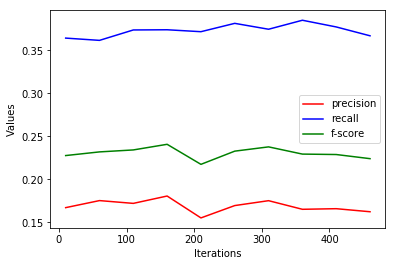

In [8]:
results = np.zeros((10,4))
range_iterations = range(10,500,50)
j = 0

# Variable params
p=0.7
features=[X_CNN] # Possible X_HOG, X_HOG, X_BOW, X_CNN -> If mf=False use only one feature inside the array
weights=[0.4, 0.6] # Sum must be one - and must always be filled even if mf=False
alpha=0.2
selection=False # False - Top K | True - Threshold
topk=3
threshold=0.05
mf=True

for i in range_iterations:
    Y_pred, y_gt = runAll(i, p, features, weights, alpha, selection, topk, threshold, mf)
    precision, recall, fscore, support = score(y_gt, Y_pred, average='macro')
    results[j] = [precision, recall, fscore, support]
    j = j+1

from sklearn.metrics import classification_report
np.set_printoptions(threshold=np.nan)

print("\nResults List:    \n{}".format(results))
print("\nResults Report:  \n{}".format(classification_report(y_gt, Y_pred)))

print("\nResults Graph:   \n")

colors = ['r', 'b', 'g']
labels = ['precision', 'recall', 'f-score']

for i in range(3):
    plt.plot(range_iterations, results[:,i], colors[i], label=labels[i])
plt.xlabel("Iterations")
plt.ylabel("Values")
plt.legend(loc='best')
plt.show()
#plt.plot(range_iterations, results[:,0], 'r', range_iterations, results[:,1], 'b', range_iterations, results[:,2], 'g')